<a href="https://colab.research.google.com/github/jhlee508/handson-ml2-study/blob/master/HoM_Ch15_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

## **15.3 시계열 예측하기**
- RNN 모델을 이용해 예측할 시계열을 임의로 만들어보자.

In [11]:
# 임의의 단변량 시계열 생성 함수
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 랜덤 균등분포
    time = np.linspace(0, 1, n_steps) # 타입 스텝 길이의 직선
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   사인곡선 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 사인곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

(3, 10, 1)


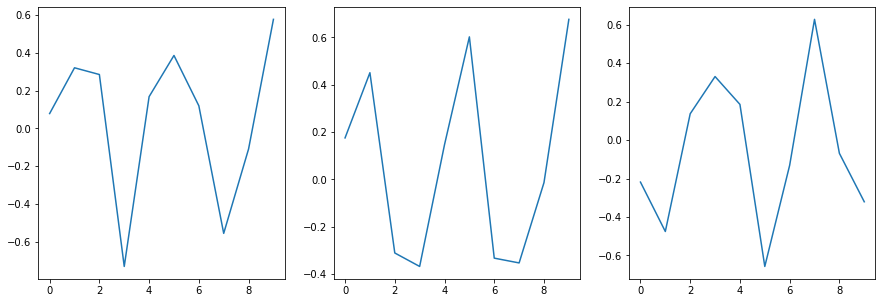

In [73]:
# 생성된 단변량 시계열 예시로 그려보기
batch_size_test = 3
time_step_test = 10

series_test = generate_time_series(batch_size, time_step)
print(series_test.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(series_test[i, :, :])
plt.show()

In [50]:
n_steps = 50 # 타임 스텝 수 = 50

series = generate_time_series(10000, n_steps + 1) # 배치 크기 = 10000, 타임 스텝 수 = 50 + '1'
series.shape

(10000, 51, 1)

In [51]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # time_step = 50, time_step = 1
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [53]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [54]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [55]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

## **15.3.1 기준 성능(Baseline Performance)**
기준 성능을 준비해야 모델의 성능을 판단할 수 있다.

### 순진한(단순한) 예측

마지막 값을 예측, 실제(다음) 값과 비교



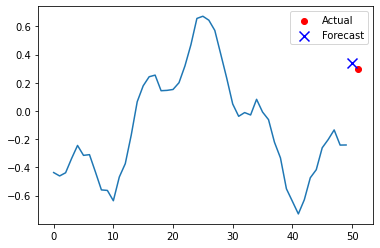

In [176]:
plt.plot(X_valid[0, :, 0]) # X_valid 첫 번째 시계열 데이터 그리기

plt.scatter(n_steps + 1, y_pred[0, 0], c = 'r', label="Actual") # 실제 값
plt.scatter(n_steps, y_valid[0, 0],marker = 'x', s = 100, c = 'b', label="Forecast") # y_valid 예측 값(마지막 값)
plt.legend(fontsize=10)
plt.show()

In [74]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.021539327

### 선형 회귀 모델 예측

In [105]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1263 - val_loss: 0.0353
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0218
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0206 - val_loss: 0.0154
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0124
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0121 - val_loss: 0.0106
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0064

In [106]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 992us/step - loss: 0.0043


0.004312956240028143

## **15.3.2 간단한 RNN 구현하기**

### Simple RNN 모델
- 하나의 뉴런(하나의 층)으로 이루어진 RNN 모델
- tanh 활성화 함수 사용
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN?version=nightly

In [126]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # 입력 시퀀스 길이 지정 필요 없음
])
print(model.summary())

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.4284 - val_loss: 0.3780
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.3678 - val_loss: 0.3339
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.3319 - val_loss: 0.2918
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.2867 - val_loss: 0.2522
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.2454 - val_loss: 0.2159
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.2105 - val_loss: 0.1838
Epoch 7/20
219/219 [=============================

In [128]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0135


0.013465875759720802

## **15.3.3 Deep RNN**
- 셀을 여러 층으로 쌓은 심층 RNN 모델

In [129]:
# SimpleRNN(유닛 또는 은닉 상태의 크기 = 20)에서 '20'은 출력 차원의 수와 같다
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
print(model.summary())

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_20 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.0342 - val_loss: 0.0040
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss:

In [130]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0033


0.003257491858676076

### 마지막 층의 은닉 상태 제거
- Dense Layer 사용
- 새로운 활성화 함수 사용 가능

In [131]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0223 - val_loss: 0.0041
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0028 - val_lo

In [132]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0026


0.002586761023849249

## 여러 타임 스텝 앞을 예측하기

### 한 번에 1 스텝 씩 10 스텝 앞을 예측하기

In [140]:
series = generate_time_series(1, n_steps + 10) # 타임 스텝 + 10

# 새로운 X, Y 생성
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

# 하나의 값을 예측하는 모델으로 하나의 값씩 총 10개 예측
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [152]:
Y_pred, Y_pred.shape

(array([[[ 0.14773878],
         [-0.03344613],
         [-0.209584  ],
         [-0.35144448],
         [-0.44680002],
         [-0.49095175],
         [-0.47742027],
         [-0.41872656],
         [-0.31667563],
         [-0.2089944 ]]], dtype=float32), (1, 10, 1))

In [178]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.0044873147

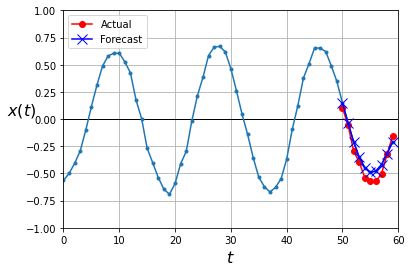

In [161]:
plot_series(X[0, :, 0])
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "ro-", label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
plt.axis([0, n_steps + 10, -1, 1])
plt.legend(fontsize=10)
plt.show()

### 다음 값 10개를 한 번에 예측
- 50개의 타임 스텝을 이용하여 다음 10개의 타임 스텝 값 예측

In [179]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10) # 타임 스텝 + 10
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] # Y 타깃을 마지막 10개의 값으로 설정
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [180]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.1022 - val_loss: 0.0340
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0319 - val_loss: 0.0228
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0145 - val_loss: 0.0134
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0093 - val_lo

In [184]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [185]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.0017953984